In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
import mogptk
import time

from waflgp import *
import utils 

In [22]:
signal = np.loadtxt('Data/hr2.txt') 
signal -=np.mean(signal)
signal /= np.sqrt(np.sum(signal**2)/len(signal))
t0 = 0
tf = 1800
Nobs =  900#1800
indices = np.arange(len(signal))
np.random.shuffle(indices)
indices = indices[:Nobs]
indices = np.sort(indices)
times = np.linspace(t0, tf,1800)

times_obs = times[indices]
signal_obs = signal[indices]

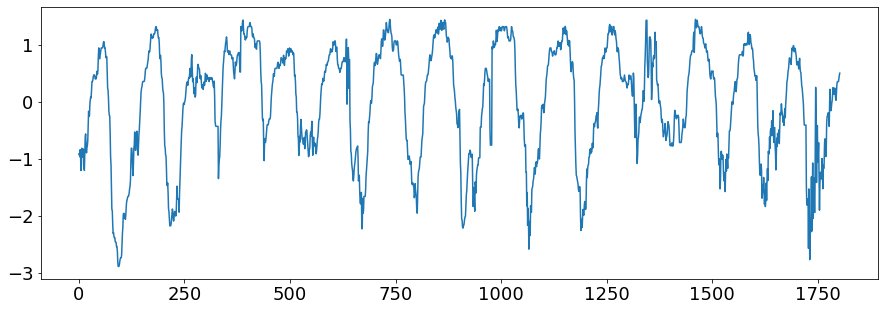

In [23]:
plt.plot(times, signal)

In [26]:
#sum of 16 SM
q = 4
gp = waflgp(space_input=times,  space_output=signal, aim = 'learning', kernel = 'qSM')
freqs = np.linspace(0,0.02,2000)
gp.set_freqs(freqs)
gp.real_world = True
t0 = time.time()
gp.train_WL(method = 'periodogram', nbins=1, metric = 'L2', order=q, w_noise=True)
time_SM = time.time() - t0

Optimization terminated successfully.
         Current function value: 0.008087
         Iterations: 17
         Function evaluations: 2709
L2-ok


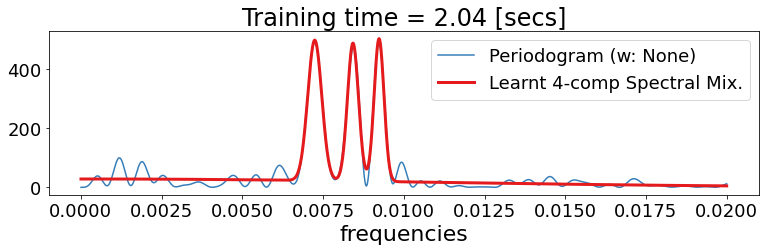

In [27]:
gp.plot_psd(title = f'Training time = {time_SM:.2f} [secs]')
#plt.savefig('Paper/img/16-specM-HR.pdf', bbox_inches='tight')

In [12]:
#sum of 16 rects
q = 4
gp = waflgp(space_input=times,  space_output=signal, aim = 'learning', kernel = 'qsinc')
gp.real_world = True
freqs = np.linspace(0,0.02,2000)
gp.set_freqs(freqs)
t0 = time.time()
gp.train_WL(method = 'periodogram', nbins=1, metric = 'L2', order=q, w_noise=True)
time_RM = time.time() - t0
    

Optimization terminated successfully.
         Current function value: 0.026820
         Iterations: 6
         Function evaluations: 1651
L2-ok


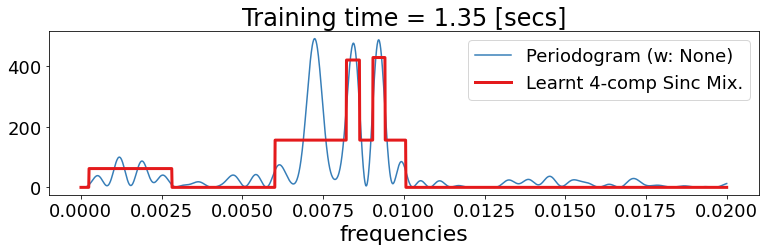

In [13]:
gp.plot_psd(title = f'Training time = {time_RM:.2f} [secs]')
#plt.savefig('Paper/img/16-sincM-HR.pdf', bbox_inches='tight')

In [23]:
components = np.array([4,8,12,16])

Q0 = components[0]
Q = components[-1]
comp_times_WAFL = np.zeros(Q+1)
comp_times_ML = np.zeros(Q+1)
comp_times_BNSE = np.zeros(Q+1)
iterations = 1500
losses = {}

for q in components:
    print(f'number of components {q}')

    #WAFL
    gp = waflgp(space_input=times,  space_output=signal, aim = 'learning', kernel = 'qSM')
    gp.real_world = True
    t0 = time.time()
    gp.train_WL(method = 'periodogram', nbins=1, order=q, w_noise=False);
    comp_times_WAFL[q] = time.time()- t0
    
    #MOGPTK
    data = mogptk.Data(times, signal, name='synth')
    model = mogptk.SM(data, Q=q)
    
    
    #Pass WAFL parameters to MOGPTK
    for qq in range(q):
        #print(f'component: {qq}')
        model.kernel[0][qq].mean.assign(gp.theta[3*qq+1])
        model.kernel[0][qq].variance.assign(gp.theta[3*qq+2])
        model.kernel[0][qq].weight.assign(gp.theta[3*qq+0]*np.var(signal))
        model.kernel.noise.assign(np.var(signal)/30)
  
    #train from SLGP   
    t0 = time.time()
    model.train('Adam', iters=iterations, lr=0.1);
    comp_times_ML[q] = time.time() - t0
    losses[f'WAFL_q:{q}'] = model.losses
    #print(f'iterac {q}: ML-like: {model.log_marginal_likelihood()}')
    
    #train from NONE
    #MOGPTK
    model_0 = mogptk.SM(data, Q=q)
    model_0.train('Adam', iters=iterations, lr=0.1);
    losses[f'0_q:{q}'] = model_0.losses
   
    #train from BNSE
    #MOGPTK
    model_bnse = mogptk.SM(data, Q=q)
    t0 = time.time()
    model_bnse.init_parameters(method='BNSE')
    comp_times_BNSE[q] = time.time() - t0 
    
    model_bnse.train('Adam', iters=iterations, lr=0.1);
    losses[f'BNSE_q:{q}'] = model_bnse.losses

number of components 4
Optimization terminated successfully.
         Current function value: 0.009747
         Iterations: 19
         Function evaluations: 3000
L2-ok
number of components 8
Optimization terminated successfully.
         Current function value: 0.007859
         Iterations: 27
         Function evaluations: 8501
L2-ok
number of components 12
Optimization terminated successfully.
         Current function value: 0.005297
         Iterations: 24
         Function evaluations: 11478
L2-ok
number of components 16
Optimization terminated successfully.
         Current function value: 0.004057
         Iterations: 34
         Function evaluations: 22064
L2-ok


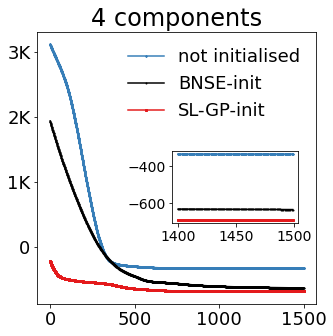

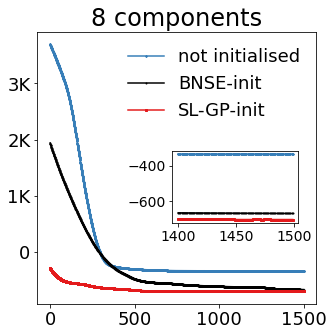

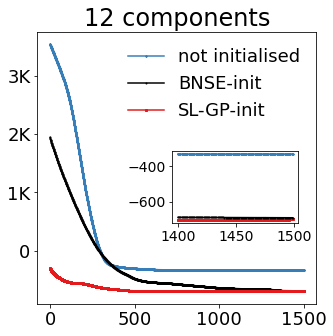

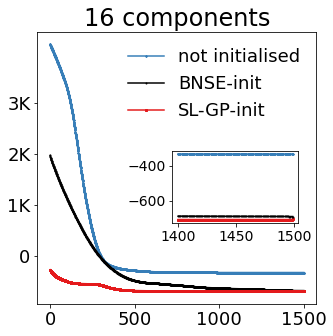

In [26]:
LC = len(components)
c = plt.cm.Set1

for q in range(LC):
    
    l_WAFL = losses[f'WAFL_q:{components[q]}']
    l_ML = losses[f'0_q:{components[q]}']
    l_BNSE = losses[f'BNSE_q:{components[q]}']
    
    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    
    plt.plot(l_ML, c = c(1), marker='*', ms = 2,label = 'not initialised')
    plt.plot(l_BNSE, c = 'k', marker='.', ms = 2,label = 'BNSE-init')
    plt.plot(l_WAFL, c = c(0), marker='s', ms = 2,label = 'SL-GP-init')
    plt.title(f'{components[q]} components')
    ax.set_yticks((0, 1000, 2000, 3000))
    ax.set_yticklabels(('0','1K','2K','3K'))
    plt.legend(frameon=False)
    
    axes = plt.axes([.50, .35, .35, .2])
    #axes.plot(l_WAFL[-100:], c='green', lw=1, label="Zoomed curve")
    axes.plot(range(1400,1500),l_WAFL[-100:], c = c(0), ms = 2, marker='s')
    axes.plot(range(1400,1500),l_ML[-100:], c = c(1), ms = 2, marker='*')
    axes.plot(range(1400,1500),l_BNSE[-100:], c = 'k', ms = 2, marker='.')
    axes.tick_params(axis='both', which='major', labelsize=14)

    #plt.savefig(f'Paper/img/losses_SM{components[q]}.pdf', bbox_inches='tight')

In [ ]:
print(f'SLGP:{comp_times_WAFL[[4,8,12,16]]}')
print(f'BNSE:{comp_times_BNSE[[4,8,12,16]]}')
print(f'ML:{comp_times_ML[[4,8,12,16]]}')